# TDDB Model Sensitivity 

Demonstration of using Gerabaldi's support for hard failure mechanisms and arbitrary custom models to simulate TDDB     failures using a custom-defined, non-algebraic model (i.e. A toy time-independent defect formation model that includes temperature and voltage dependence. Not a proposed TDDB defect formation model.)

---------------------------------------------------------------------------------------------------------------------------

Copyright (c) 2023 Ian Hill

SPDX-License-Identifier: Apache-2.0

## 0. Library Installation

In [1]:
pip install gerabaldi

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install reliability

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gerabaldi 
from gerabaldi.models import * 
from gerabaldi.helpers import _on_demand_import

import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib
from multiprocessing import Pool
import time as t
import numpy as np
import pandas as pd

import reliability

## 1. Functions Definition

In [4]:
def defect_generator_demo_model(time, temp, v_g, t_diel, c, bond_strength, thermal_dist):
    defect_gen_prob = c * (v_g / t_diel) * ((temp ** thermal_dist) / bond_strength)
    prob = time * defect_gen_prob
    return 1 if Uniform().sample() < prob else 0


def oxide_failed(init, cond, threshold, defect0, defect1, defect2, defect3, defect4, defect5, # noqa: UnusedParameter
                 defect6, defect7, defect8, defect9, defect10, defect11):
    # We physically model a transistor oxide layer with 12 possible defect locations
    layout = np.array([defect0, defect1, defect2, defect3, defect4, defect5,
                       defect6, defect7, defect8, defect9, defect10, defect11]).reshape((3, 4))
    # Determine defects formed based on whether the stochastic defect formation value has hit a threshold
    oxide = pd.DataFrame(layout).applymap(lambda deg: 1 if deg > threshold else 0)
    # Identify if any of the columns in our oxide layer have fully defected
    conductive_col = False
    for i in range(len(oxide.columns)):
        if (oxide[i] == 1).all():
            conductive_col = True
            break
    # The transistor gate oxide breaks down if a conductive channel has formed in a column
    return 0 if conductive_col or init == 0 else 1


def single_test(step_val, test):
    ########################################################################
    ### 2. Define the test/field environment                             ###
    ########################################################################
    field_env = PhysTestEnv(env_vrtns={
        'temp': EnvVrtnMdl(dev_vrtn_mdl=Gamma(2, 1), chp_vrtn_mdl=Normal(0, 0.3)),
        'v_g': EnvVrtnMdl(dev_vrtn_mdl=Normal(0, 0.001), chp_vrtn_mdl=Normal(0, 0.003))
    }, meas_instms={
        'temp': MeasInstrument(error=Normal(0, 1), precision=4, meas_lims=(-40, 150))
    })

    ########################################################################
    ### 3. Define the physical device model                              ###
    ########################################################################
    defect_mdl = FailMechMdl(defect_generator_demo_model,
                             c=LatentVar(deter_val=C_LATENT),
                             t_diel=LatentVar(deter_val=3),
                             bond_strength=LatentVar(deter_val=200),
                             thermal_dist=LatentVar(deter_val=step_val))  # <-- This is what we are schmooing
    defect_dict = {'defect' + str(i): defect_mdl for i in range(0, 12)}

    tddb_model = DeviceMdl(DegPrmMdl(
        prm_name='tddb',
        # We set the initial state to be where all transistor oxides are unbroken,
        # however we could model manufacturing defects by modifying this
        init_val_mdl=InitValMdl(init_val=LatentVar(deter_val=1)),
        deg_mech_mdls=defect_dict,
        compute_eqn=oxide_failed,
        array_computable=False,
        threshold=LatentVar(deter_val=0.5)
    ))

    return gerabaldi.simulate(test, tddb_model, field_env)


def simulate(save_files: dict = None):

    CELSIUS_TO_KELVIN = 273.15

    ########################################################################
    ### 1. Define the test to simulate                                   ###
    ########################################################################
    weekly_moderate_use = StrsSpec({'temp': 65 + CELSIUS_TO_KELVIN, 'v_g': 0.9}, 30, 'Moderate Loading')
    weekly_intensive_use = StrsSpec({'temp': 88 + CELSIUS_TO_KELVIN, 'v_g': 0.92}, 16, 'Heavy Loading')
    weekly_idle_use = StrsSpec({'temp': 30 + CELSIUS_TO_KELVIN, 'v_g': 0.87}, 122, 'Idle State')

    check_for_fails = MeasSpec(
        {'tddb': NUM_SAMPLES}, {'temp': 35 + CELSIUS_TO_KELVIN, 'v_g': 0.9}, print_action=True, name='FailCheck')

    field_use_sim = TestSpec([check_for_fails], name='Field Use Sim', description='Test spec designed to represent a \
        real-world use scenario for a consumer device with downtime and higher stress periods.')
    field_use_sim.append_steps(
        [weekly_moderate_use, weekly_intensive_use, weekly_idle_use, check_for_fails], loop_for_duration=TEST_LEN)

    ########################################################################
    ### 4. Simulate the test                                             ###
    ########################################################################
    rprts = []
    start_time = t.time()
    for step in DATA_FILES:
        test_out = single_test(step, field_use_sim) 
        rprts.append(test_out)
    print(f"Simulation time: {t.time() - start_time} seconds")

    # Save the simulated results to JSON files for reuse if desired
    if save_files:
        for i, rep in enumerate(DATA_FILES):
            rprts[i].export_to_json(save_files[rep], 'hours')
    return {rep: rprts[i] for i, rep in enumerate(DATA_FILES)}


def visualize(rprts):
    
    SECONDS_PER_HOUR = 3600
    
    fail_data = {}
    for rep in rprts:
        fail_data[rep] = rprts[rep].measurements
    clr_map = {1.05: 'limegreen', 1.075: 'turquoise', 1.1: 'dodgerblue', 1.125: 'blueviolet', 1.15: 'maroon'}
    sb.set_theme(style='ticks', font='Times New Roman')
    plt.figure(figsize=(10, 6))

    # Need to reformat data to be the failure times of each transistor
    fails = []
    schmoos = []
    fail_event_data = pd.DataFrame()
    for step in rprts:
        meas = rprts[step].measurements
        for sample in meas['device #'].unique():
            # Get measurements for only the one sample
            sample_meas = meas.loc[meas['device #'] == sample]
            # Extract the first row where the transistor fails
            index = sample_meas['measured'].ne(1).idxmax()
            if sample_meas.loc[index]['measured'] == 0:
                fails.append(sample_meas.loc[index]['time'].total_seconds() / SECONDS_PER_HOUR)
                schmoos.append(step)
            else:
                # Most transistors won't have failed, these are marked as right-censored data
                fails.append('right-censored')
                schmoos.append(step)
    fail_event_data['param val'] = schmoos
    fail_event_data['time'] = fails

    # Fit each test to a Weibull distribution
    dsets = {}
    fits = {}
    x = np.vstack([np.zeros(5), np.ones(5)]).T
    y = np.zeros(5)
    for i, prm_val in enumerate(clr_map):
        dsets[prm_val] = fail_event_data.loc[fail_event_data['param val'] == prm_val]
        unobserved = dsets[prm_val].loc[dsets[prm_val]['time'] == 'right-censored'].copy()
        unobserved.loc[:, 'time'] = TEST_LEN

        observed = dsets[prm_val].loc[dsets[prm_val]['time'] != 'right-censored'].copy()
        fits[prm_val] = reliability.Fitters.Fit_Weibull_2P(
            observed['time'].tolist(), right_censored=unobserved['time'].tolist(), quantiles=True,
            print_results=False, show_probability_plot=True, color=clr_map[prm_val],
            label=f"$\\alpha$ = {prm_val}")
        quantile = fits[prm_val].quantiles.loc[0]
        print(f"{prm_val}: 95% CI of <1% transistors failing: {quantile['Lower Estimate']} hours")
        x[i][0] = prm_val
        y[i] = quantile['Lower Estimate']

    plt.axvline(2 * 8.736e4, color='black', linestyle='dashed', label='Simulation Stop Point')
    plt.text(0.9, 0.15, 'Simulation Stop: 20 Years', ha='center', color='black',
             rotation=90, fontsize='small', transform=plt.gca().transAxes)
    plt.ylabel("Percent Failing")
    plt.xlabel("Failure Time (hours)")
    plt.grid(alpha=0.2)
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gcf().set_size_inches(8, 6)
    plt.title('Sensitivity of TDDB Failure Rates to Shifts in Model Parameter $\\alpha$ Using Weibull Fits.')

    # Do a quick linear regression on the output worst-case CDF, report slope
    sensitivity, bias = np.linalg.lstsq(x, y, rcond=None)[0]
    print(f"Expected decrease in 1% failure time across parameter range: {sensitivity * 0.1}")
    plt.show()


## 2. Outputs

In [5]:
# General Variables

DATA_FILES = {1.05: 'tddb_1.05_report', 1.075: 'tddb_1.075_report', 1.1: 'tddb_1.1_report',
              1.125: 'tddb_1.125_report', 1.15: 'tddb_1.15_report'}

TEST_LEN = 24 * 7 * 52  * 1
NUM_SAMPLES = 100
C_LATENT = 4e-3

### 2.1 Measurements DataFrame 

In [6]:
report = simulate()

Conducted measurement FailCheck at simulation time 0:00:00.
Conducted measurement FailCheck at simulation time 7 days, 0:00:00.
Conducted measurement FailCheck at simulation time 14 days, 0:00:00.
Conducted measurement FailCheck at simulation time 21 days, 0:00:00.
Conducted measurement FailCheck at simulation time 28 days, 0:00:00.
Conducted measurement FailCheck at simulation time 35 days, 0:00:00.
Conducted measurement FailCheck at simulation time 42 days, 0:00:00.
Conducted measurement FailCheck at simulation time 49 days, 0:00:00.
Conducted measurement FailCheck at simulation time 56 days, 0:00:00.
Conducted measurement FailCheck at simulation time 63 days, 0:00:00.
Conducted measurement FailCheck at simulation time 70 days, 0:00:00.
Conducted measurement FailCheck at simulation time 77 days, 0:00:00.
Conducted measurement FailCheck at simulation time 84 days, 0:00:00.
Conducted measurement FailCheck at simulation time 91 days, 0:00:00.
Conducted measurement FailCheck at simulatio

Conducted measurement FailCheck at simulation time 91 days, 0:00:00.
Conducted measurement FailCheck at simulation time 98 days, 0:00:00.
Conducted measurement FailCheck at simulation time 105 days, 0:00:00.
Conducted measurement FailCheck at simulation time 112 days, 0:00:00.
Conducted measurement FailCheck at simulation time 119 days, 0:00:00.
Conducted measurement FailCheck at simulation time 126 days, 0:00:00.
Conducted measurement FailCheck at simulation time 133 days, 0:00:00.
Conducted measurement FailCheck at simulation time 140 days, 0:00:00.
Conducted measurement FailCheck at simulation time 147 days, 0:00:00.
Conducted measurement FailCheck at simulation time 154 days, 0:00:00.
Conducted measurement FailCheck at simulation time 161 days, 0:00:00.
Conducted measurement FailCheck at simulation time 168 days, 0:00:00.
Conducted measurement FailCheck at simulation time 175 days, 0:00:00.
Conducted measurement FailCheck at simulation time 182 days, 0:00:00.
Conducted measurement 

Conducted measurement FailCheck at simulation time 175 days, 0:00:00.
Conducted measurement FailCheck at simulation time 182 days, 0:00:00.
Conducted measurement FailCheck at simulation time 189 days, 0:00:00.
Conducted measurement FailCheck at simulation time 196 days, 0:00:00.
Conducted measurement FailCheck at simulation time 203 days, 0:00:00.
Conducted measurement FailCheck at simulation time 210 days, 0:00:00.
Conducted measurement FailCheck at simulation time 217 days, 0:00:00.
Conducted measurement FailCheck at simulation time 224 days, 0:00:00.
Conducted measurement FailCheck at simulation time 231 days, 0:00:00.
Conducted measurement FailCheck at simulation time 238 days, 0:00:00.
Conducted measurement FailCheck at simulation time 245 days, 0:00:00.
Conducted measurement FailCheck at simulation time 252 days, 0:00:00.
Conducted measurement FailCheck at simulation time 259 days, 0:00:00.
Conducted measurement FailCheck at simulation time 266 days, 0:00:00.
Conducted measuremen

In [7]:
PROCESS_TO_DISPLAY = list(DATA_FILES.keys())[0] # <- Modify this int for another process
print(f'Displaying DataFrames for "{PROCESS_TO_DISPLAY}"')

Displaying DataFrames for "1.05"


In [8]:
report[PROCESS_TO_DISPLAY].measurements.head(10)

,param,device #,chip #,lot #,time,measured
0,tddb,0,0,0,0 days,1
1,tddb,1,0,0,0 days,1
2,tddb,2,0,0,0 days,1
3,tddb,3,0,0,0 days,1
4,tddb,4,0,0,0 days,1
5,tddb,5,0,0,0 days,1
6,tddb,6,0,0,0 days,1
7,tddb,7,0,0,0 days,1
8,tddb,8,0,0,0 days,1
9,tddb,9,0,0,0 days,1


In [9]:
report[PROCESS_TO_DISPLAY].stress_summary.head(10)

,stress step,duration,start time,end time,temp,v_g
0,Moderate Loading,1 days 06:00:00,0 days 00:00:00,1 days 06:00:00,338.15,0.9
1,Heavy Loading,0 days 16:00:00,1 days 06:00:00,1 days 22:00:00,361.15,0.92
2,Idle State,5 days 02:00:00,1 days 22:00:00,7 days 00:00:00,303.15,0.87
3,Moderate Loading,1 days 06:00:00,7 days 00:00:00,8 days 06:00:00,338.15,0.9
4,Heavy Loading,0 days 16:00:00,8 days 06:00:00,8 days 22:00:00,361.15,0.92
5,Idle State,5 days 02:00:00,8 days 22:00:00,14 days 00:00:00,303.15,0.87
6,Moderate Loading,1 days 06:00:00,14 days 00:00:00,15 days 06:00:00,338.15,0.9
7,Heavy Loading,0 days 16:00:00,15 days 06:00:00,15 days 22:00:00,361.15,0.92
8,Idle State,5 days 02:00:00,15 days 22:00:00,21 days 00:00:00,303.15,0.87
9,Moderate Loading,1 days 06:00:00,21 days 00:00:00,22 days 06:00:00,338.15,0.9


### 2.2 Report Visualization 

1.05: 95% CI of <1% transistors failing: 61.124654156159394 hours
1.075: 95% CI of <1% transistors failing: 53.74170121658385 hours
1.1: 95% CI of <1% transistors failing: 46.59737955478152 hours
1.125: 95% CI of <1% transistors failing: 44.55904418899403 hours
1.15: 95% CI of <1% transistors failing: 41.08067477723224 hours
Expected decrease in 1% failure time across parameter range: -19.7082463141777


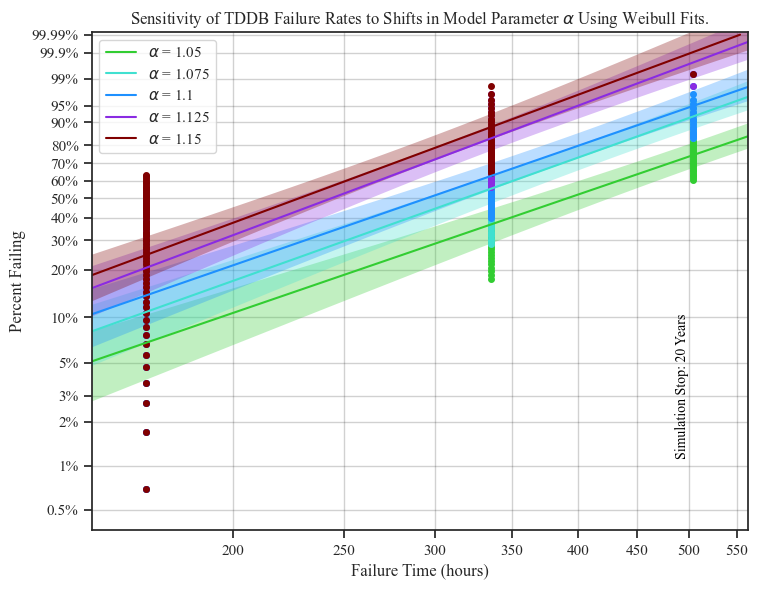

In [10]:
visualize(report)